# Azure Cognitive Search Vector Search Code Sample with Azure AI Vision Image Embedding API
This code demonstrates how to create Azure Cognitive Search Index with Azure AI Vision Image Embedding API and Azure Python SDK

### Set up a Python virtual environment in Visual Studio Code

1. Open the Command Palette (Ctrl+Shift+P).
1. Search for **Python: Create Environment**.
1. Select **Venv**.
1. Select a Python interpreter. Choose 3.10 or later.

It can take a minute to set up. If you run into problems, see [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments).

### Install packages

In [ ]:
! pip install -r requirements.txt --quiet

### Load .env file (Copy .env-sample to .env and update accordingly)

In [4]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AzureKeyCredential
import os

load_dotenv(override=True) # take environment variables from .env.

# Variables not used here do not need to be updated in your .env file
endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"]) if len(os.environ["AZURE_SEARCH_ADMIN_KEY"]) > 0 else DefaultAzureCredential()
index_name = os.environ["AZURE_SEARCH_INDEX"]
vision_key = os.environ["AZURE_AI_VISION_KEY"]
vision_endpoint = os.environ["AZURE_AI_VISION_ENDPOINT"]

# Create image embedding

Vectorize images with image embedding API 

In [12]:
import requests
import os
from tenacity import (
    Retrying,
    retry_if_exception_type,
    wait_random_exponential,
    stop_after_attempt
)
import json
import mimetypes

params = {  
        "api-version": "2023-02-01-preview",
        "overload": "stream",
        "modelVersion": "latest"
}
url = f"{vision_endpoint}/computervision/retrieval:vectorizeImage"  

def vectorize_image(image_path):
    mime_type, _ = mimetypes.guess_type(image_path)
    headers = {  
        "Content-Type": mime_type,
        "Ocp-Apim-Subscription-Key": vision_key  
    }
    for attempt in Retrying(
        retry=retry_if_exception_type(requests.HTTPError),
        wait=wait_random_exponential(min=15, max=60),
        stop=stop_after_attempt(15)
    ):
        with attempt:
            with open(image_path, 'rb') as image_data:
                response = requests.post(url, params=params, headers=headers, data=image_data)  
                if response.status_code != 200:  
                    response.raise_for_status()
    vector = response.json()["vector"]
    return vector

Vectorize all the images and save them into a [json lines](https://jsonlines.org/) file

In [13]:
apples_image_directory = os.path.join('..', 'data', 'images', 'apples')
input_json_file = os.path.join(apples_image_directory, 'input.json')
output_json_file = os.path.join(apples_image_directory, 'output.jsonl')
with open(input_json_file, 'r') as infile:
    images = json.load(infile)

with open(output_json_file, 'w') as outfile:
    for idx, image_data in enumerate(images):
        image_path = image_data.get('image_path', None)
        if image_path:
            try:
                vector = vectorize_image(os.path.join(apples_image_directory, image_path))
            except Exception as e:
                print(f"Error processing image at index {idx}: {e}")
                vector = None
            
            filename, _ = os.path.splitext(os.path.basename(image_path))
            result = {
                "id": f'{idx}',
                "image_vector": vector,
                "description": filename
            }

            outfile.write(json.dumps(result))
            outfile.write('\n')
            outfile.flush()

print(f"Results are saved to {output_json_file}")

Results are saved to ..\data\images\apples\output.jsonl


# Create an index

Create your search index schema and vector search configuration:

In [14]:
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    SimpleField,
    SearchField,
    SearchFieldDataType,
    VectorSearch,
    HnswAlgorithmConfiguration,
    VectorSearchProfile,
    SearchIndex
)

# Create a search index 
index_client = SearchIndexClient(endpoint=endpoint, credential=credential)  
fields = [  
    SimpleField(name="id", type=SearchFieldDataType.String, key=True),  
    SearchField(name="description", type=SearchFieldDataType.String, sortable=True, filterable=True, facetable=True),  
    SearchField(
        name="image_vector",  
        hidden=True,
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single), 
        searchable=True,
        vector_search_dimensions=1024,  
        vector_search_profile_name="myHnswProfile"
    ),  
]  
  
# Configure the vector search configuration  
vector_search = VectorSearch(  
    algorithms=[  
        HnswAlgorithmConfiguration(  
            name="myHnsw"
        )
    ],  
   profiles=[  
        VectorSearchProfile(  
            name="myHnswProfile",  
            algorithm_configuration_name="myHnsw",  
        )
    ],  
)  
  
# Create the search index with the vector search configuration  
index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)  
result = index_client.create_or_update_index(index)  
print(f"{result.name} created") 

images-sample created


# Push local data to the index

In [16]:
from azure.search.documents import SearchClient
import json

apples_image_directory = os.path.join('..', 'data', 'images', 'apples')
output_json_file = os.path.join(apples_image_directory, 'output.jsonl')

data = []
with open(output_json_file, 'r') as file:
    for line in file:
        # Remove leading/trailing whitespace and parse JSON
        json_data = json.loads(line.strip())
        data.append(json_data)

search_client = SearchClient(endpoint=endpoint, index_name=index_name, credential=credential)
results = search_client.upload_documents(data)
for result in results:
    print(f'Indexed {result.key} with status code {result.status_code}')

Indexed 0 with status code 200
Indexed 1 with status code 200
Indexed 2 with status code 200
Indexed 3 with status code 200
Indexed 4 with status code 200
Indexed 5 with status code 200
Indexed 6 with status code 200
Indexed 7 with status code 200
Indexed 8 with status code 200
Indexed 9 with status code 200


# Perform an image vector search
Perform a vector search to find the most relevant images based on an image query

Search results for ..\data\images\apples\two_apples.jpeg:


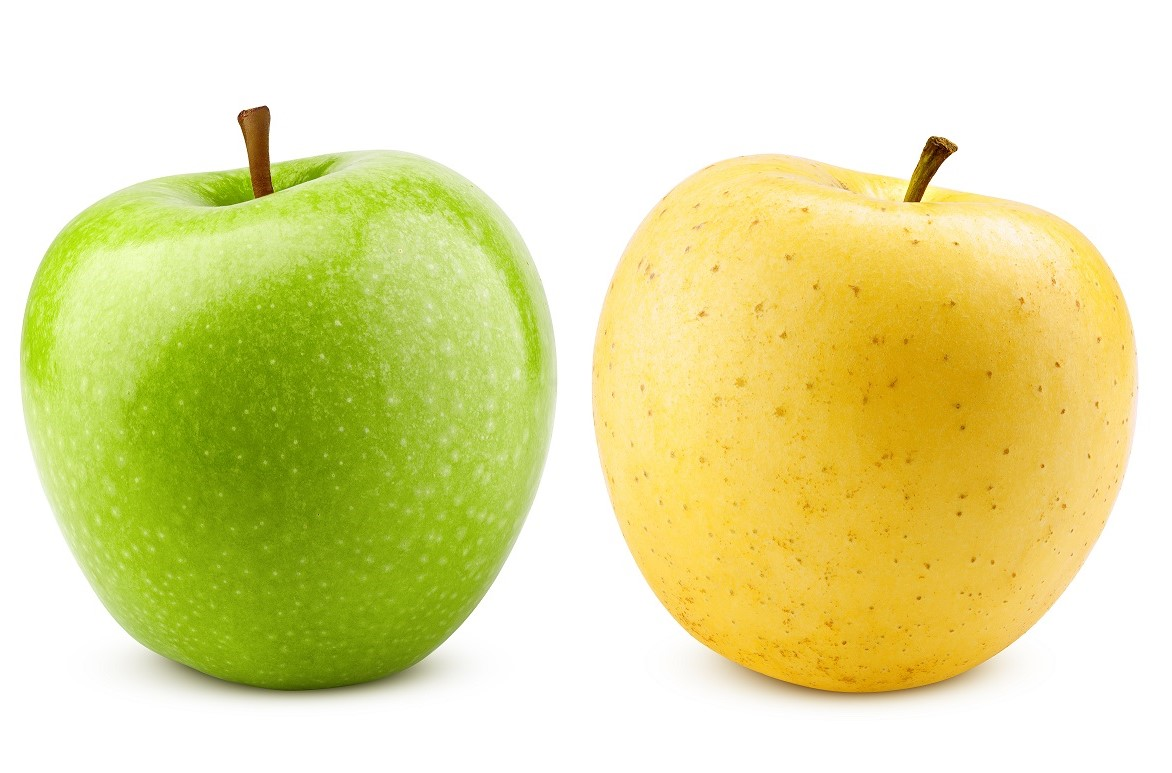

Apple Type: GoldenDelicious


Apple Type: GrannySmith




In [24]:
from azure.search.documents.models import VectorizedQuery
from IPython.display import Image

# Generate text embeddings for the query  
query_image_path = os.path.join(apples_image_directory, "two_apples.jpeg")
vector_query = VectorizedQuery(vector=vectorize_image(query_image_path),
                              k_nearest_neighbors=2, 
                              fields="image_vector")  

# Perform vector search  
results = search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["description"],
    top=2
)   
  
# Print the search results 
print(f"Search results for {query_image_path}:") 
display(Image(query_image_path))
for result in results:
    print(f"Apple Type: {result['description']}")
    print("\n") 